In [26]:
import compute_rmse
from keras import backend as K
import math
from numpy.random import seed
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from keras import callbacks
from keras import layers
from tensorflow import keras
import tensorflow as tf
print("Tensor flow version: " + tf.__version__)
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
%matplotlib inline
warnings.filterwarnings('ignore')

# Data Preprocessing
seed(42)
tf.random.set_seed(42)


Tensor flow version: 2.10.0


# Split

In [27]:
def split_data(ds):
    ds_train, val_test_ds = train_test_split(ds, test_size=0.2, random_state=1)
    ds_valid, ds_test = train_test_split(
        val_test_ds, test_size=0.5, random_state=1)
    return ds_train, ds_valid, ds_test


In [28]:
transformer_cat = make_pipeline(OneHotEncoder(handle_unknown='ignore'))


In [29]:
transformer_num = make_pipeline(MinMaxScaler())


In [30]:
features_num = [
    'fixed acidity', 'volatile acidity',
    'citric acid', 'residual sugar', 'chlorides',
    'free sulfur dioxide', 'total sulfur dioxide',
    'density', 'pH', 'sulphates', 'alcohol'
]

features_cat = ['type']

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat)
)


In [31]:
def load_data(ds_train, ds_test):

    X_train = ds_train.drop('quality', axis=1)
    X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
    X_train.columns = features_num + ["type_red", "type_white"]

    y_train = ds_train['quality']

    X_test = ds_test.drop('quality', axis=1)
    X_test = pd.DataFrame(preprocessor.transform(X_test))
    X_test.columns = features_num + ['type_red', 'type_white']

    y_test = ds_test['quality']
    return X_train, X_test, y_train, y_test


# Load data

In [32]:
data_dir = 'input/train.csv'


In [33]:
cheat_dir = 'input/cheating_data.csv'


In [34]:
cheat = pd.read_csv(cheat_dir)


In [35]:
cheat


,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,1257,7.2,0.2,0.37,2.5,0.063,11.0,41.0,0.9944,3.52,0.80,12.4,red,7.0
1,6409,8.2,0.3,0.39,7.8,0.039,49.0,208.0,0.9976,3.31,0.51,9.5,white,6.0
2,136,8.9,0.3,0.49,1.6,0.050,17.0,131.0,0.9956,3.13,0.34,9.4,white,5.0
3,1631,7.4,0.2,0.30,13.7,0.056,33.0,168.0,0.9982,2.90,0.44,8.7,white,7.0
4,6084,6.4,0.3,0.56,1.7,0.156,49.0,106.0,0.9935,3.10,0.37,9.2,white,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,4646,6.1,0.3,0.56,2.7,0.046,46.0,184.0,0.9924,3.31,0.57,10.9,white,6.0
816,734,6.7,0.3,0.34,6.6,0.067,35.0,156.0,0.9954,3.11,0.48,9.3,white,6.0
817,5090,8.3,0.3,0.37,1.4,0.076,8.0,23.0,0.9974,3.26,0.70,9.6,red,6.0
818,1579,6.3,0.3,0.29,3.3,0.037,32.0,140.0,0.9895,3.17,0.36,12.8,white,7.0


In [36]:
ds = pd.read_csv(data_dir, sep=';', decimal='.')


In [37]:
ds


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,6.6,0.3,0.36,1.2,0.035,43,126,0.9909,3.01,0.63,11.4,6,white
1,7.7,0.5,0.26,1.9,0.062,9,31,0.9966,3.39,0.64,9.6,5,red
2,8.4,0.5,0.35,2.9,0.076,21,127,0.9976,3.23,0.63,9.2,5,red
3,7.5,0.4,0.33,5.0,0.045,30,131,0.9942,3.32,0.44,10.9,6,white
4,6.4,0.2,0.25,20.2,0.083,35,157,0.9998,3.17,0.50,9.1,5,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6709,7.2,0.2,0.19,7.7,0.045,53,176,0.9958,3.17,0.38,9.5,5,white
6710,6.7,0.3,0.34,7.5,0.036,39,124,0.9912,2.99,0.32,12.4,8,white
6711,6.6,0.3,0.24,3.3,0.034,29,99,0.9903,3.10,0.40,12.3,7,white
6712,8.0,0.2,0.31,5.6,0.049,24,97,0.9930,3.10,0.42,10.9,5,white


append cheat data

In [38]:
ds = ds.append(cheat.drop('id', axis=1)[
               ds.columns].sample(frac=0.3), ignore_index=True)
ds


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,6.6,0.3,0.36,1.2,0.035,43.0,126.0,0.9909,3.01,0.63,11.4,6.0,white
1,7.7,0.5,0.26,1.9,0.062,9.0,31.0,0.9966,3.39,0.64,9.6,5.0,red
2,8.4,0.5,0.35,2.9,0.076,21.0,127.0,0.9976,3.23,0.63,9.2,5.0,red
3,7.5,0.4,0.33,5.0,0.045,30.0,131.0,0.9942,3.32,0.44,10.9,6.0,white
4,6.4,0.2,0.25,20.2,0.083,35.0,157.0,0.9998,3.17,0.50,9.1,5.0,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6955,6.7,0.3,0.25,8.0,0.053,54.0,202.0,0.9961,3.22,0.43,9.3,5.0,white
6956,6.5,0.4,0.23,8.3,0.051,28.0,91.0,0.9952,3.44,0.55,12.1,6.0,red
6957,7.0,0.2,0.30,6.1,0.037,31.0,120.0,0.9939,3.24,0.51,10.8,5.0,white
6958,6.3,0.3,0.32,1.5,0.030,24.0,101.0,0.9892,3.21,0.42,13.0,5.0,white


In [39]:
ds.isnull().values.any()


False

In [40]:
ds_train, ds_valid, ds_test = split_data(ds)


In [41]:
ds_train


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
636,6.0,0.2,0.29,1.1,0.047,67.0,152.0,0.9916,3.54,0.59,11.1,7.0,white
6786,7.2,0.4,0.63,11.0,0.044,55.0,156.0,0.9974,3.09,0.44,8.7,6.0,white
81,7.4,0.7,0.01,1.9,0.085,8.0,22.0,0.9983,3.61,0.97,9.8,6.0,red
3285,9.7,0.3,0.47,1.6,0.062,13.0,33.0,0.9983,3.27,0.66,10.0,6.0,red
6397,11.5,0.4,0.53,3.3,0.107,35.0,99.0,1.0010,3.20,0.95,9.3,6.0,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,9.6,0.4,0.31,2.6,0.096,15.0,49.0,0.9981,3.17,0.70,10.0,6.0,red
5192,6.5,0.3,0.42,10.6,0.042,66.0,202.0,0.9967,3.24,0.53,9.5,6.0,white
3980,8.0,0.7,0.56,2.0,0.118,30.0,134.0,0.9968,3.24,0.66,9.4,5.0,red
235,8.3,0.2,0.37,7.9,0.025,38.0,107.0,0.9931,2.93,0.37,11.9,6.0,white


In [42]:
X_train, X_valid, y_train, y_valid = load_data(ds_train, ds_valid)


In [43]:
X_train


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,0.175000,0.083333,0.174699,0.007669,0.063123,0.229167,0.336406,0.086705,0.635659,0.207865,0.449275,0.0,1.0
1,0.275000,0.250000,0.379518,0.159509,0.058140,0.187500,0.345622,0.198459,0.286822,0.123596,0.101449,0.0,1.0
2,0.291667,0.500000,0.006024,0.019939,0.126246,0.024306,0.036866,0.215800,0.689922,0.421348,0.260870,1.0,0.0
3,0.483333,0.166667,0.283133,0.015337,0.088040,0.041667,0.062212,0.215800,0.426357,0.247191,0.289855,1.0,0.0
4,0.633333,0.250000,0.319277,0.041411,0.162791,0.118056,0.214286,0.267823,0.372093,0.410112,0.188406,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,0.475000,0.250000,0.186747,0.030675,0.144518,0.048611,0.099078,0.211946,0.348837,0.269663,0.289855,1.0,0.0
5564,0.216667,0.166667,0.253012,0.153374,0.054817,0.225694,0.451613,0.184971,0.403101,0.174157,0.217391,0.0,1.0
5565,0.341667,0.500000,0.337349,0.021472,0.181063,0.100694,0.294931,0.186898,0.403101,0.247191,0.202899,1.0,0.0
5566,0.366667,0.083333,0.222892,0.111963,0.026578,0.128472,0.232719,0.115607,0.162791,0.084270,0.565217,0.0,1.0


In [44]:
ds_orig = pd.read_csv(data_dir, sep=';', decimal='.')
ds_orig.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,6.6,0.3,0.36,1.2,0.035,43,126,0.9909,3.01,0.63,11.4,6,white
1,7.7,0.5,0.26,1.9,0.062,9,31,0.9966,3.39,0.64,9.6,5,red
2,8.4,0.5,0.35,2.9,0.076,21,127,0.9976,3.23,0.63,9.2,5,red
3,7.5,0.4,0.33,5.0,0.045,30,131,0.9942,3.32,0.44,10.9,6,white
4,6.4,0.2,0.25,20.2,0.083,35,157,0.9998,3.17,0.50,9.1,5,white


# Model

In [45]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [46]:
# Defining callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='root_mean_squared_error',
    patience=50,  # how many epochs to wait before stopping
    min_delta=0.001,  # minimium amount of change to count as an improvement
    restore_best_weights=True,
    verbose=1
)

lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='root_mean_squared_error',
    patience=0,
    factor=0.2,
    min_lr=0.001,
    verbose=1
)


In [47]:
# Combine training set and validation set to train final model
ds_train = ds_train.append(ds_valid)

# Execute load_data() for prediction
X_train, X_test, y_train, y_test = load_data(ds_train, ds_test)


In [48]:
# Training configuration
BATCH_SIZE = 2 ** 8

# Model Configuration
UNITS = 2 ** 10
ACTIVATION = 'relu'
DROPOUT = 0.2


In [49]:
# Build final model from scratch

def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    def make(inputs):
        x = layers.Dense(units)(inputs)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.BatchNormalization()(x)
        return x
    return make


# Model
inputs = keras.Input(shape=(13,))
x = dense_block(UNITS, ACTIVATION, DROPOUT)(inputs)
x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)


# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss=root_mean_squared_error,
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


# Fit model (and save training history)
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=3000,
    callbacks=[early_stopping, lr_schedule],
    verbose=1,
)


# Making predictions from test set
predictions = model.predict(X_test)


# Evaluate
model_score = mean_squared_error(y_test, predictions, squared=False)
print("Final model score (RMSE):", model_score)


Epoch 1/3000
25/25 [==============================] - 3s 76ms/step - loss: 5.6851 - root_mean_squared_error: 5.7100 - lr: 0.0010
Epoch 2/3000
25/25 [==============================] - 2s 75ms/step - loss: 4.4350 - root_mean_squared_error: 4.4542 - lr: 0.0010
Epoch 3/3000
25/25 [==============================] - 2s 76ms/step - loss: 2.6347 - root_mean_squared_error: 2.7023 - lr: 0.0010
Epoch 4/3000
25/25 [==============================] - 2s 77ms/step - loss: 1.5502 - root_mean_squared_error: 1.5532 - lr: 0.0010
Epoch 5/3000
25/25 [==============================] - 2s 75ms/step - loss: 1.3798 - root_mean_squared_error: 1.3815 - lr: 0.0010
Epoch 6/3000
 9/25 [=========>....................] - ETA: 1s - loss: 1.2997 - root_mean_squared_error: 1.3009

In [ ]:
test_raw = pd.read_csv('input/test.csv', sep=';', decimal='.')
test_raw


,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,1257,7.2,0.25,0.37,2.5,0.063,11.0,41.0,0.99439,3.52,0.80,12.4,red
1,6409,8.2,0.27,0.39,7.8,0.039,49.0,208.0,0.99760,3.31,0.51,9.5,white
2,136,8.9,0.32,0.49,1.6,0.050,17.0,131.0,0.99560,3.13,0.34,9.4,white
3,1631,7.4,0.16,0.30,13.7,0.056,33.0,168.0,0.99825,2.90,0.44,8.7,white
4,6084,6.4,0.28,0.56,1.7,0.156,49.0,106.0,0.99354,3.10,0.37,9.2,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,4646,6.1,0.30,0.56,2.7,0.046,46.0,184.0,0.99240,3.31,0.57,10.9,white
816,734,6.7,0.33,0.34,6.6,0.067,35.0,156.0,0.99542,3.11,0.48,9.3,white
817,5090,8.3,0.26,0.37,1.4,0.076,8.0,23.0,0.99740,3.26,0.70,9.6,red
818,1579,6.3,0.29,0.29,3.3,0.037,32.0,140.0,0.98950,3.17,0.36,12.8,white


In [ ]:
test = pd.DataFrame(preprocessor.transform(test_raw))
test.columns = features_num + ['type_red', 'type_white']
test


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,0.280992,0.125000,0.222892,0.029141,0.089701,0.072464,0.103550,0.140462,0.620155,0.325843,0.637681,1.0,0.0
1,0.363636,0.141667,0.234940,0.110429,0.049834,0.347826,0.597633,0.202312,0.457364,0.162921,0.217391,0.0,1.0
2,0.421488,0.183333,0.295181,0.015337,0.068106,0.115942,0.369822,0.163776,0.317829,0.067416,0.202899,0.0,1.0
3,0.297521,0.050000,0.180723,0.200920,0.078073,0.231884,0.479290,0.214836,0.139535,0.123596,0.101449,0.0,1.0
4,0.214876,0.150000,0.337349,0.016871,0.244186,0.347826,0.295858,0.124085,0.294574,0.084270,0.173913,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,0.190083,0.166667,0.337349,0.032209,0.061462,0.326087,0.526627,0.102119,0.457364,0.196629,0.420290,0.0,1.0
816,0.239669,0.191667,0.204819,0.092025,0.096346,0.246377,0.443787,0.160308,0.302326,0.146067,0.188406,0.0,1.0
817,0.371901,0.133333,0.222892,0.012270,0.111296,0.050725,0.050296,0.198459,0.418605,0.269663,0.231884,1.0,0.0
818,0.206612,0.158333,0.174699,0.041411,0.046512,0.224638,0.396450,0.046243,0.348837,0.078652,0.695652,0.0,1.0


In [ ]:
predictions_test = model.predict(test)
quality = pd.DataFrame(data=predictions_test, columns=['quality'])
quality


26/26 [==============================] - 0s 7ms/step


,quality
0,5.997050
1,6.052374
2,5.075049
3,6.997692
4,6.081541
...,...
815,6.611998
816,6.088221
817,6.459033
818,6.535687


In [ ]:
quality.insert(0, 'id', test_raw['id'], True)
quality


,id,quality
0,1257,5.997050
1,6409,6.052374
2,136,5.075049
3,1631,6.997692
4,6084,6.081541
...,...,...
815,4646,6.611998
816,734,6.088221
817,5090,6.459033
818,1579,6.535687


In [ ]:
quality.to_csv('submission.csv', index=False)


<AxesSubplot:xlabel='quality', ylabel='Count'>

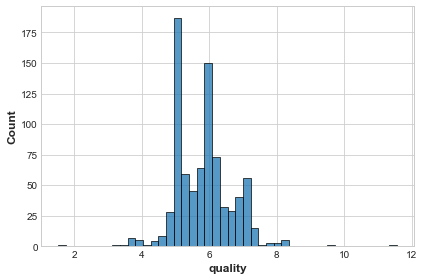

In [ ]:
sns.histplot(data=quality, x='quality')
sns.scatterplot(data=quality, x='quality')


In [ ]:
# Place data into DataFrame for readability
X_test_frame = pd.DataFrame(X_test)
X_test_frame.columns = ['fixed acidity', 'volatile acidity', 'citric acid',
                        'residual sugar', 'chlorides', 'free sulfur dioxide',
                        'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
                        'red', 'white']

X_train_frame = pd.DataFrame(X_train)
X_train_frame.columns = ['fixed acidity', 'volatile acidity', 'citric acid',
                         'residual sugar', 'chlorides', 'free sulfur dioxide',
                         'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
                         'red', 'white']


In [ ]:
# Summarize the training set to accelerate analysis
X_train_frame = shap.kmeans(X_train_frame.values, 25)


In [ ]:
# Instantiate an explainer with the model predictions and training data (or training data summary)
explainer = shap.KernelExplainer(model.predict, X_train_frame)


1/1 [==============================] - 0s 129ms/step


In [ ]:
# Extract Shapley values from the explainer
# Select test data representing red wine category
shap_values = explainer.shap_values(
    X_test_frame[X_test_frame['red'] == 1][:400])


  0%|          | 0/185 [00:00<?, ?it/s]

1621/1621 [==============================] - 12s 7ms/step


  1%|          | 1/185 [00:12<39:39, 12.93s/it]

1621/1621 [==============================] - 9s 6ms/step


  1%|          | 2/185 [00:22<34:16, 11.24s/it]

1621/1621 [==============================] - 10s 6ms/step


  2%|▏         | 3/185 [00:33<32:42, 10.78s/it]

1621/1621 [==============================] - 10s 6ms/step


  2%|▏         | 4/185 [00:43<31:51, 10.56s/it]

1621/1621 [==============================] - 9s 6ms/step


  3%|▎         | 5/185 [00:53<30:56, 10.31s/it]

1621/1621 [==============================] - 9s 6ms/step


  3%|▎         | 6/185 [01:03<30:17, 10.15s/it]

1621/1621 [==============================] - 9s 6ms/step


  4%|▍         | 7/185 [01:12<29:40, 10.00s/it]

1621/1621 [==============================] - 9s 6ms/step


  4%|▍         | 8/185 [01:22<29:29, 10.00s/it]

1621/1621 [==============================] - 10s 6ms/step


  5%|▍         | 9/185 [01:33<29:56, 10.21s/it]

1621/1621 [==============================] - 11s 7ms/step


  5%|▌         | 10/185 [01:44<30:49, 10.57s/it]

1621/1621 [==============================] - 11s 7ms/step


  6%|▌         | 11/185 [01:56<31:21, 10.81s/it]

1621/1621 [==============================] - 11s 7ms/step


  6%|▋         | 12/185 [02:07<31:44, 11.01s/it]

1621/1621 [==============================] - 9s 6ms/step


  7%|▋         | 13/185 [02:17<30:37, 10.68s/it]

1621/1621 [==============================] - 9s 5ms/step


  8%|▊         | 14/185 [02:27<29:25, 10.32s/it]

1621/1621 [==============================] - 9s 5ms/step


  8%|▊         | 15/185 [02:36<28:29, 10.05s/it]

1621/1621 [==============================] - 9s 6ms/step


  9%|▊         | 16/185 [02:46<27:57,  9.93s/it]

1621/1621 [==============================] - 9s 6ms/step


  9%|▉         | 17/185 [02:55<27:38,  9.87s/it]

1621/1621 [==============================] - 10s 6ms/step


 10%|▉         | 18/185 [03:06<28:19, 10.18s/it]

1621/1621 [==============================] - 10s 6ms/step


 10%|█         | 19/185 [03:17<28:40, 10.36s/it]

1621/1621 [==============================] - 10s 6ms/step


 11%|█         | 20/185 [03:28<28:44, 10.45s/it]

1621/1621 [==============================] - 9s 6ms/step


 11%|█▏        | 21/185 [03:37<27:51, 10.19s/it]

1621/1621 [==============================] - 10s 6ms/step


 12%|█▏        | 22/185 [03:48<28:00, 10.31s/it]

1621/1621 [==============================] - 10s 6ms/step


 12%|█▏        | 23/185 [03:59<28:21, 10.50s/it]

1621/1621 [==============================] - 11s 7ms/step


 13%|█▎        | 24/185 [04:11<29:07, 10.85s/it]

1621/1621 [==============================] - 10s 6ms/step


 14%|█▎        | 25/185 [04:21<28:33, 10.71s/it]

1621/1621 [==============================] - 9s 6ms/step


 14%|█▍        | 26/185 [04:31<27:46, 10.48s/it]

1621/1621 [==============================] - 9s 6ms/step


 15%|█▍        | 27/185 [04:41<27:07, 10.30s/it]

1621/1621 [==============================] - 9s 6ms/step


 15%|█▌        | 28/185 [04:51<26:51, 10.26s/it]

1552/1621 [===========================>..] - ETA: 0s

 15%|█▌        | 28/185 [05:01<28:11, 10.77s/it]


KeyboardInterrupt: 